In [1]:
import os
import numpy as np
import importlib

import torch
from torch.utils.data import DataLoader

from utils.common import plot_hist_seaborn, plot_ROC_curve, read_annotations, load_config
from utils.evaluation import evaluate_multiclass, metric_ood, compute_oscr
from data.dataset import ImageDataset
from models.models import Simple_CNN

In [2]:
def get_feature(model, dataloader, config, device):
    model.eval()
    Loss = importlib.import_module('loss.' + config.loss)
    criterion = getattr(Loss, config.loss)(config).to(device)
    with torch.no_grad():
        features = []
        labels =[]
        probs=[]
        for i, batch in enumerate(dataloader):
            input_img_batch, label_batch, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)
            label = label_batch.reshape((-1)).to(device)
            prob, feature = model(input_img, data='dct')
            prob, _ = criterion(feature, prob)

            if i == 0:
                probs = prob
                gt_labels = label
                features = feature
            else:
                probs = torch.cat([probs, prob], dim=0)
                gt_labels = torch.cat([gt_labels, label])
                features=torch.cat(([features, feature]))

    features = features.cpu().numpy()
    probs = probs.cpu().numpy()
    labels = gt_labels.cpu().numpy()
        
    return features, labels, probs

In [3]:
def calculate_open_set_result(_labels_k, _labels_u, _pred_k, _pred_u, known_feature, unknown_feature, known_classes, unknown_classes, save_dir):
    
    x1, x2 = np.max(_pred_k, axis=1), np.max(_pred_u, axis=1)
    out_results = metric_ood(x1, x2)['Bas'] # check
    _oscr_socre = compute_oscr(_pred_k, _pred_u, _labels_k)
    unknown_perf = round(out_results['AUROC'], 2)

    print("AUC, OSCR : {:.2f} {:.2f}".format(unknown_perf, _oscr_socre*100))

    # plot confidence histogram and ROC curve
    os.makedirs(save_dir, exist_ok=True)
    plot_hist_seaborn(x1, x2, save_path = os.path.join(save_dir,'hist.png'))
    plot_ROC_curve(out_results, save_path = os.path.join(save_dir,'roc.png'))
    
    # print detailed results for each unknown class
    for i, label_u in enumerate(set(_labels_u)):
        pred_u = _pred_u[_labels_u==label_u]
        x1, x2 = np.max(_pred_k, axis=1), np.max(pred_u, axis=1)
        pred = np.argmax(pred_u, axis=1)
        pred_labels = list(set(pred))
        pred_nums = [np.sum(pred==p) for p in pred_labels]
        result = metric_ood(x1, x2, verbose=False)['Bas']
        print("{}\t \t mostly pred class: {}\t \t average score: {}\t AUROC (%): {:.2f}".format(unknown_classes[i], 
                                                                                 known_classes[pred_labels[np.argmax(pred_nums)]],
                                                                                 np.mean(x2), result['AUROC']))

In [4]:
device = 'cuda:6'
config = load_config('configs.{}'.format('progressive'))

# load model
model_path = './checkpoints/split1/model.pth'
model = Simple_CNN(class_num=15, out_feature_result=True)
pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
model.load_state_dict(pretrained_dict)
model = model.to(device)

In [5]:
test_data_path = './dataset/subset_annotations/test.txt'
close_set = ImageDataset(read_annotations(test_data_path), config, balance=False, test_mode=True)
close_loader = DataLoader(
    dataset=close_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
known_feature, known_label, known_prob  = get_feature(model, close_loader, config, device)
pred_labels = np.argmax(known_prob, axis=1)
results = evaluate_multiclass(known_label, pred_labels)
print('closed-set accuracy', round(results['acc'], 4)*100)

/data/yangtianyun/code/GAN_OSR/POSE_CVPR/loss/Softmax.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


closed-set accuracy 92.13


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    11.500 73.744 70.500 82.686 57.481
AUC, OSCR : 73.74 70.83


/data/yangtianyun/code/GAN_OSR/POSE_CVPR/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/data/yangtianyun/code/GAN_OSR/POSE_CVPR/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


celeba_ProGAN_seed1	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6567210555076599	 AUROC (%): 64.19
celeba_ProGAN_seed2	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6636733412742615	 AUROC (%): 64.83
celeba_ProGAN_seed3	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6582597494125366	 AUROC (%): 65.99
celeba_ProGAN_seed4	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6737707257270813	 AUROC (%): 63.73
celeba_ProGAN_seed5	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.6199973225593567	 AUROC (%): 70.26
lsun_ProGAN_seed1	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.473407506942749	 AUROC (%): 86.16
lsun_ProGAN_seed2	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.5637748837471008	 AUROC (%): 78.31
lsun_ProGAN_seed3	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.49888306856155396	 AUROC (%): 84.46
lsun_ProGAN_seed4	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 

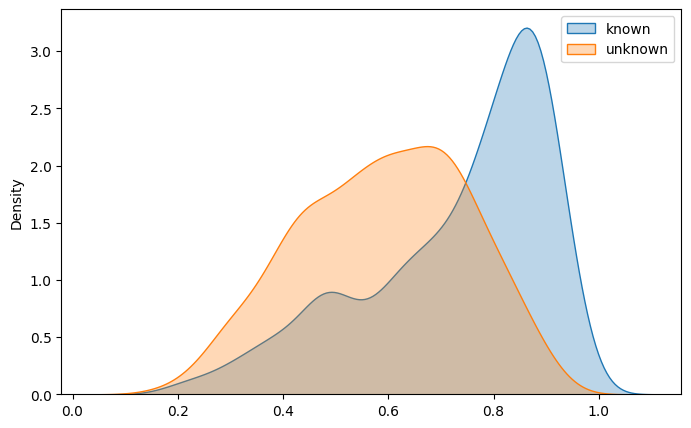

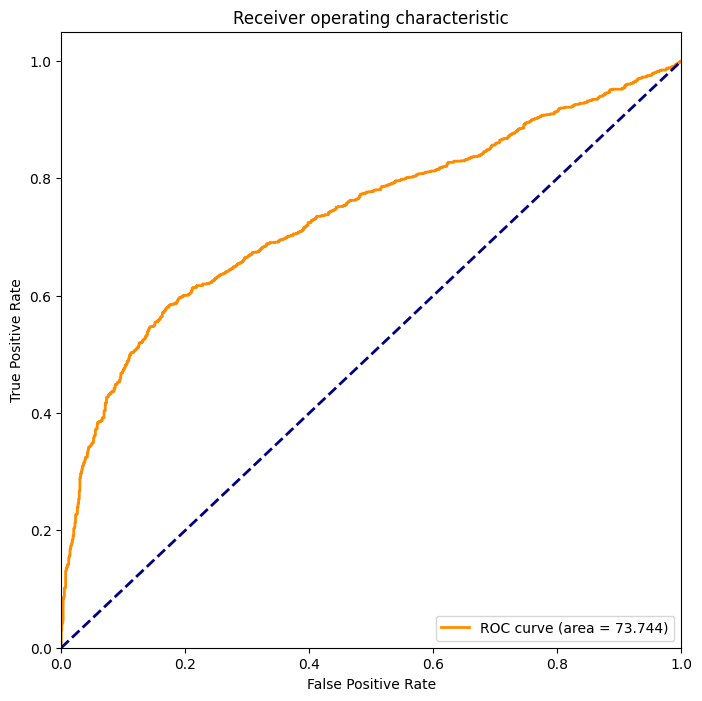

In [6]:
out_data_path = './dataset/subset_annotations/test_out_seed.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob  = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['celeba_ProGAN_seed1', 'celeba_ProGAN_seed2', 'celeba_ProGAN_seed3', 'celeba_ProGAN_seed4', 'celeba_ProGAN_seed5',\
                   'lsun_ProGAN_seed1', 'lsun_ProGAN_seed2', 'lsun_ProGAN_seed3', 'lsun_ProGAN_seed4', 'lsun_ProGAN_seed5']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_seed')


/data/yangtianyun/code/GAN_OSR/POSE_CVPR/loss/Softmax.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    51.318 87.193 79.735 80.936 90.589
AUC, OSCR : 87.19 81.92


/data/yangtianyun/code/GAN_OSR/POSE_CVPR/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/data/yangtianyun/code/GAN_OSR/POSE_CVPR/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


celeba_MMDGAN	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.29544636607170105	 AUROC (%): 97.19
celeba_AttGAN	 	 mostly pred class: lsun_MMDGAN	 	 average score: 0.2517206370830536	 AUROC (%): 98.50
celeba_SNGAN	 	 mostly pred class: celeba_ProGAN_seed0	 	 average score: 0.5690904855728149	 AUROC (%): 76.42
celeba_InfomaxGAN	 	 mostly pred class: real	 	 average score: 0.2868265211582184	 AUROC (%): 97.02
FFHQ_StyleGAN2	 	 mostly pred class: FFHQ_StyleGAN3_r	 	 average score: 0.5846076011657715	 AUROC (%): 77.27
CelebA_HQ_ProGAN	 	 mostly pred class: real	 	 average score: 0.4734441637992859	 AUROC (%): 86.50
CelebA_HQ_StyleGAN	 	 mostly pred class: real	 	 average score: 0.4831277132034302	 AUROC (%): 85.84
BigGAN_imagenet	 	 mostly pred class: real	 	 average score: 0.267170250415802	 AUROC (%): 98.00
S3GAN_imagenet	 	 mostly pred class: lsun_MMDGAN	 	 average score: 0.27357134222984314	 AUROC (%): 97.03
ContraGAN_imagenet	 	 mostly pred class: real	 	 average score: 

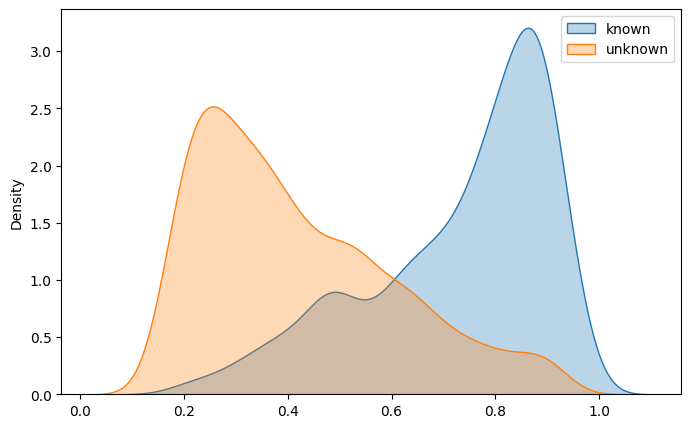

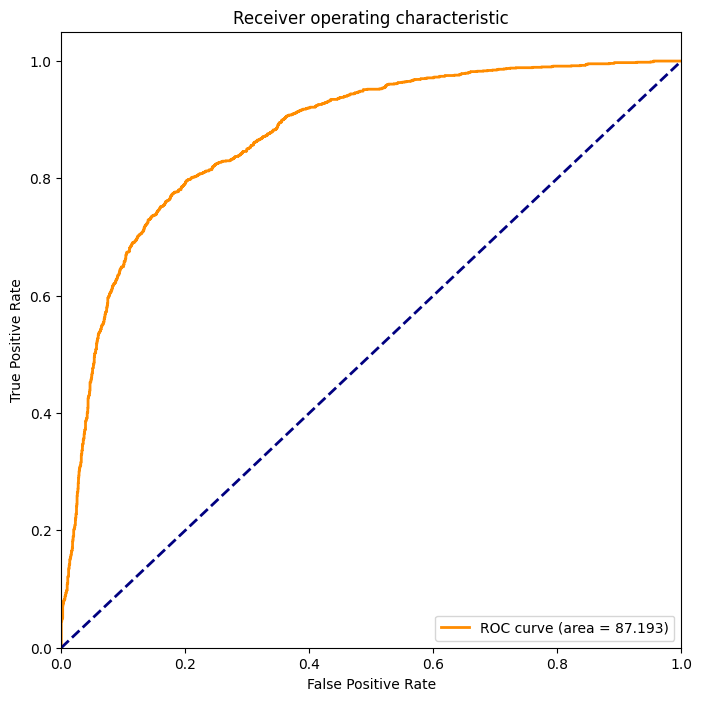

In [7]:
out_data_path = './dataset/subset_annotations/test_out_arch.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['celeba_MMDGAN', 'celeba_AttGAN', 'celeba_SNGAN', 'celeba_InfomaxGAN', \
                   'FFHQ_StyleGAN2', 'CelebA_HQ_ProGAN', 'CelebA_HQ_StyleGAN', \
                   'BigGAN_imagenet', 'S3GAN_imagenet', 'ContraGAN_imagenet', \
                   'lsun_SNGAN', 'lsun_InfomaxGAN', \
                   'Faceshifter', 'wav2lip', \
                   'stylegan2_cat', 'progan_cat', 'mmdgan_cat', 'sngan_cat', \
                   'stylegan2_bus', 'stylegan3_bus', 'mmdgan_bus', 'sngan_bus']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_arch')

/data/yangtianyun/code/GAN_OSR/POSE_CVPR/loss/Softmax.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    52.143 89.915 82.581 87.970 90.803
AUC, OSCR : 89.91 84.42


/data/yangtianyun/code/GAN_OSR/POSE_CVPR/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/data/yangtianyun/code/GAN_OSR/POSE_CVPR/utils/common.py:89: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


stylegan_airplane	 	 mostly pred class: stylegan_bus	 	 average score: 0.35567083954811096	 AUROC (%): 92.66
stylegan_bridge	 	 mostly pred class: stylegan_bus	 	 average score: 0.45788559317588806	 AUROC (%): 86.26
stylegan_church_outdoor	 	 mostly pred class: progan_bus	 	 average score: 0.3467405438423157	 AUROC (%): 95.04
stylegan_classroom	 	 mostly pred class: stylegan_bus	 	 average score: 0.3380349278450012	 AUROC (%): 95.31
stylegan_cow	 	 mostly pred class: stylegan_bus	 	 average score: 0.30331599712371826	 AUROC (%): 96.28
stylegan_kitchen	 	 mostly pred class: lsun_ProGAN_seed0	 	 average score: 0.3627610504627228	 AUROC (%): 94.33
stylegan_sheep	 	 mostly pred class: stylegan_bus	 	 average score: 0.32467642426490784	 AUROC (%): 94.55
stylegan3_airplane	 	 mostly pred class: stylegan3_cat	 	 average score: 0.39125606417655945	 AUROC (%): 91.71
stylegan3_bridge	 	 mostly pred class: stylegan3_cat	 	 average score: 0.3938571512699127	 AUROC (%): 91.68
stylegan3_church_outdo

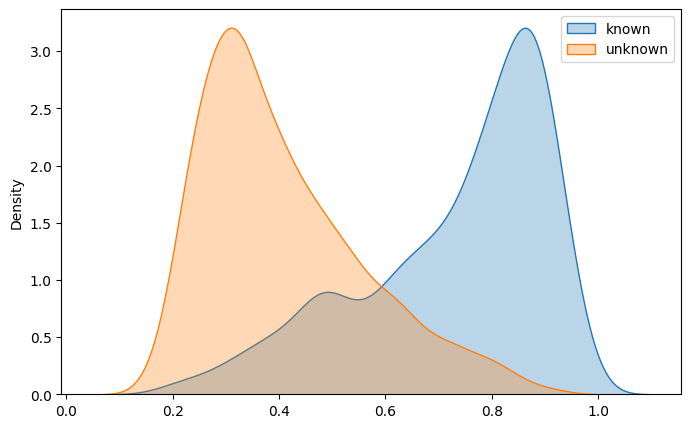

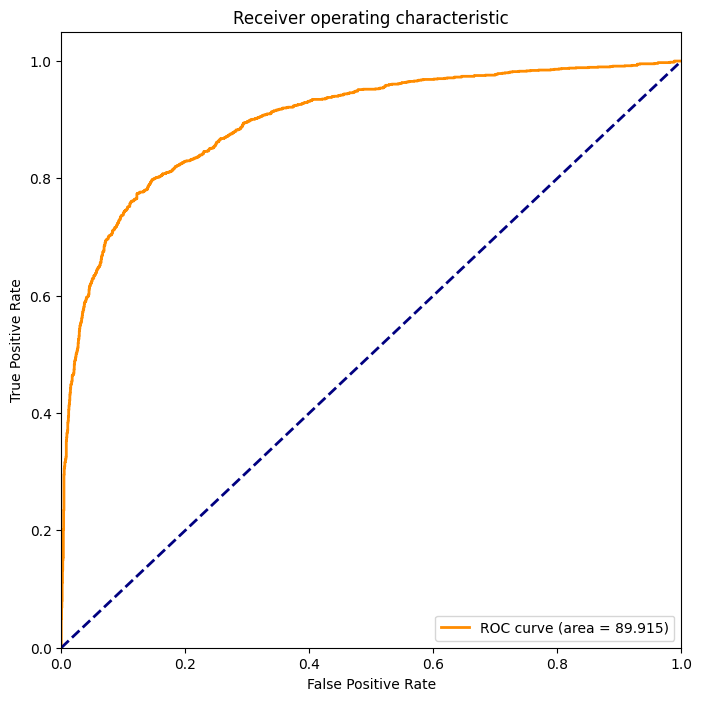

In [8]:
# result on unseen dataset 
out_data_path = './dataset/subset_annotations/test_out_dataset.txt'
out_set = ImageDataset(read_annotations(out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
out_feature, out_label, out_prob  = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN_seed0', 'celeba_StarGAN', 'FFHQ_StyleGAN3_r', 'FFHQ_StyleGAN3_t', 'SNGAN_imagenet', 'SAGAN_imagenet', 'lsun_ProGAN_seed0', 'lsun_MMDGAN', 'FaceSwap', 'FSGAN', 'stylegan_cat', 'stylegan3_cat', 'stylegan_bus', 'progan_bus']
unknown_classes = ['stylegan_airplane', 'stylegan_bridge', 'stylegan_church_outdoor', 'stylegan_classroom', 'stylegan_cow', 'stylegan_kitchen', 'stylegan_sheep', \
                   'stylegan3_airplane', 'stylegan3_bridge', 'stylegan3_church_outdoor', 'stylegan3_classroom', 'stylegan3_cow', 'stylegan3_kitchen', 'stylegan3_sheep', \
                   'progan_airplane', 'progan_bridge', 'progan_church_outdoor', 'progan_classroom', 'progan_cow', 'progan_kitchen', 'progan_sheep']
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_dataset')
